In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import cvxpy as cp
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

# from utils_opt import *

%load_ext autoreload
%autoreload 2

# Test active learning approach

In [2]:
# make fake data
n, d = 1000, 15
Sigma = np.random.normal(size=(d, d))
Sigma = Sigma.T @ Sigma
mu = np.random.normal(size=d)
# assume moving average system
X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=n)

beta = np.random.uniform(1, 100, size=d)
f = X@beta + np.random.normal(size=n)

In [33]:
D = 10
X = np.load('../data/pca_encoding.npy')[:,:D]
n, d = X.shape
# columns=['index', sample_num', 'operating_cost', 'market_rev', 'runtime'
f = pd.read_csv('../data/combined_hvdc.csv', header=None).to_numpy()[:,2]

In [34]:
fscale = StandardScaler().fit_transform(f.reshape(-1,1)).flatten()
Xscale = StandardScaler().fit_transform(X)

## Gaussian process tools

In [35]:
def kernel(xi, xj):
    return np.exp((-1/2)*np.dot(xi - xj, xi - xj))

def K(Xk):
    K = np.array([np.diagonal((Xk[i] - Xk) @ (Xk[i] - Xk).T) for i in range(len(Xk))])
    K = np.exp(-0.5*K)
    return K

def kx(x, Xk):
    return np.array([kernel(x, xk) for xk in Xk])

def gp_mean(x, Xk, fk):
    return kx(x, Xk) @ np.linalg.inv(K(Xk)) @ fk

def gp_var(x, Xk):
    return kernel(x, x) - kx(x, Xk).T @ np.linalg.inv(K(Xk)) @ kx(x, Xk)

## Maximum entropy search tools

In [36]:
def entropy(x, Xk):
    return (1/2) * np.log(2*np.pi*gp_var(x, Xk)) + (1/2)

def f_obj(x, Xk):
    '''this is the true objective we want to minimize'''
    return kx(x, Xk).T @ np.linalg.inv(K(Xk)) @ kx(x, Xk)

def gradf_obj(x, Xk):
    k, d = Xk.shape
    Kinv = np.linalg.inv(K(Xk))
    gradf = np.zeros(d)
    for i in range(k):
        for j in range(k):
            gradf += Kinv[i,j]*kernel(x, Xk[i])*kernel(x,Xk[j])*(-2*(x - 0.5*(Xk[i] + Xk[j])))
    return gradf

def hessf_obj(x, Xk):
    k, d = Xk.shape
    Kinv = np.linalg.inv(K(Xk))
    hessf = np.zeros((d,d))
    for i in range(k):
        for j in range(k):
            hess_ij = 4*np.outer((x - (1/2)*(Xk[i] + Xk[j])), x - (1/2)*(Xk[i] + Xk[j])) - 2*np.identity(d)
            hess_ij *= Kinv[i,j]*kernel(x, Xk[i])*kernel(x,Xk[j])
            hessf +=  hess_ij

    return hessf

def proj_hess(H):
    lam, Q = np.linalg.eig(H)
    idx_poslam = np.where(lam > 0)[0]
    projH = Q[idx_poslam].T @ np.diag(lam[idx_poslam].real) @ Q[idx_poslam]
    return projH

In [37]:
def fhat_obj_taylor(x:cp.Variable, xk:np.array, Xk:np.array):
    P = proj_hess(hessf_obj(xk, Xk))
    delta = x - xk
    return f_obj(xk, Xk) + gradf_obj(xk, Xk)@delta + cp.quad_form(delta, P, assume_PSD=True)

# optimization
def scp_step_taylor(xk, Xk, rho):
    k, d = Xk.shape
    x = cp.Variable(d)
    constraints = [cp.abs(x) <= rho]

    prob = cp.Problem(cp.Minimize(fhat_obj_taylor(x, xk, Xk)), constraints)
    prob.solve()
    
    return prob.value, x.value

def scp_taylor(x0, rho0, Xk, alpha=0.1, beta=[1.1, 0.5], num_iters=50):
    # initialize
    xk = x0
    rho = rho0
    f_objs, dec_preds, decs = [], [], []
    
    # sequentially optimize
    for i in range(num_iters):
        fhatp, xkp = scp_step_taylor(xk, Xk, rho)
    
        # update rho
        dec_pred = f_obj(xk, Xk) - fhat_obj_taylor(xkp, xk, Xk).value
        dec = f_obj(xk, Xk) - f_obj(xkp, Xk)
        # log stuff
        f_objs += [f_obj(xk, Xk)]
        dec_preds += [dec_pred]
        decs += [dec]

        # update rho
        if dec >= alpha*dec_pred:
            rho *= beta[0]
            xk = xkp
        else:
            rho *= beta[1]
        
    return xk, (f_objs, dec_preds, decs)

In [38]:
def fhat_obj_particle(x, xk, P, q, r):
    delta = x - xk
    obj = cp.quad_form(delta, P, assume_PSD=True) + q@delta + r
    return obj

def fit_quadratic(xk, Xk, rho, num_samples):

    # sample data
    samples = []
    for i in range(num_samples):
        sample = np.array([np.random.uniform(-rho[i], rho[i]) for i in range(d)])
        samples += [sample]
    samples = np.array(samples)

    # fit quadratic
    P = cp.Variable((d,d), PSD=True)
    q = cp.Variable(d)
    r = cp.Variable()
    constraints = [P >> 0]

    obj = 0.0
    for sample in samples:
        obj += cp.square(fhat_obj_particle(sample, xk, P, q, r) - f_obj(sample, Xk))
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver='SCS')
    
    return P.value, q.value, r.value

# optimization
def scp_step_particle(xk, Xk, rho, num_samples=50):
    k, d = Xk.shape
    x = cp.Variable(d)
    constraints = [cp.abs(x) <= rho]
    
    P, q, r = fit_quadratic(xk, Xk, rho, num_samples)
    prob = cp.Problem(cp.Minimize(fhat_obj_particle(x, xk, P, q, r)), constraints)
    prob.solve()
    
    return prob.value, x.value, (P, q, r)

def scp_particle(x0, rho0, Xk, alpha=0.1, beta=[1.1, 0.5], num_iters=50):
    # initialize
    xk = x0
    rho = rho0
    f_objs, dec_preds, decs = [], [], []
    
    # sequentially optimize
    for i in range(num_iters):
        fhatp, xkp, (P, q, r) = scp_step_particle(xk, Xk, rho)
    
        # update rho
        dec_pred = f_obj(xk, Xk) - fhat_obj_particle(xkp, xk, P, q, r).value
        dec = f_obj(xk, Xk) - f_obj(xkp, Xk)
        # log stuff
        f_objs += [f_obj(xk, Xk)]
        dec_preds += [dec_pred]
        decs += [dec]

        # update rho
        if dec >= alpha*dec_pred:
            rho *= beta[0]
            xk = xkp
        else:
            rho *= beta[1]
        
    return xk, (f_objs, dec_preds, decs)

In [39]:
class dict_list(dict):
    def __init__(self):
        super(dict_list, self).__init__()
        self.__dict__ = self
        
    def add(self, k, v):
        if k in self:
            self[k].append(v)
        else:
            self[k] = [v]      

In [40]:
def get_stats(results, f, fpred):
    percentiles = [0, 10, 25, 50, 75, 90, 100]
    for p in percentiles:
        results.add(f'pctl_{p}', np.percentile(fpred, p))
    results.add('mean', np.mean(fpred))
    results.add('std', np.std(fpred))
    # comparison stats
    results.add('ttest', sps.ttest_ind(f, fpred).pvalue)
    results.add('komolgorov', sps.ks_2samp(f, fpred).pvalue)
    
    return results

## Pipeline

In [45]:
n0 = 5
N = 50

# initialize
results = dict_list()
idx_init = np.random.randint(0, len(Xscale), n0)
Xk = Xscale[idx_init]
Xleft = np.array([x for x in Xscale if x not in Xk])
fk = fscale[idx_init]
x0 = Xscale.mean(axis=0)
rho0 = 0.1*np.maximum(np.abs(Xscale.min(axis=0)), np.abs(Xscale.max(axis=0)))

idxs = []
for k in tqdm(range(N)):
    # choose next sample
    xk, __ = scp_particle(Xscale[np.random.randint(0, len(Xscale))], rho0, Xk, num_iters=15)

    # find sample x closest to selected x
    xk_idx = np.argmin(np.linalg.norm(Xleft - xk, ord=2, axis=1))
#     xk_idx = np.argmin(np.array([f_obj(x, Xk) for x in Xleft]))
    idxs += [xk_idx]

    # run model and add (x,f) to dataset
    Xk = np.vstack([Xk, Xleft[xk_idx]])
    Xleft = np.array([x for x in Xscale if x not in Xk])
    fk = np.append(fk, fscale[xk_idx])

    # run surrogate model for all samples
    fpred = np.array([gp_mean(x, Xk, fk) for x in Xscale])
    
    # calculate statistics
    results = get_stats(results, fscale, fpred.copy())

100%|███████████████████████████████████████████| 50/50 [02:15<00:00,  2.70s/it]


## Visualize

# tODO -- Quantile test
https://freakonometrics.hypotheses.org/4199

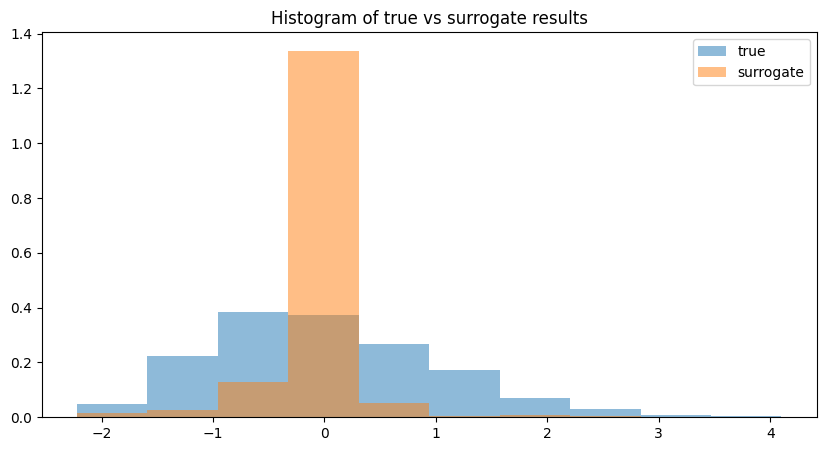

In [46]:
rlow, rhigh = np.minimum(np.min(fscale), np.min(fpred)), np.maximum(np.max(fscale), np.max(fpred))
plt.figure(figsize=(10,5))
plt.hist(fscale, alpha=0.5, label='true', range=(rlow, rhigh), density=True)
plt.hist(fpred, alpha=0.5, label='surrogate', range=(rlow, rhigh), density=True)
plt.title('Histogram of true vs surrogate results')
plt.legend()
plt.show()

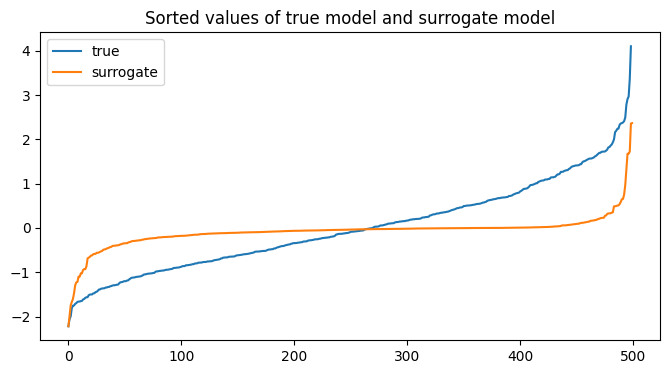

In [47]:
plt.figure(figsize=(8,4))
plt.plot(np.sort(fscale), label='true')
plt.plot(np.sort(fpred), label='surrogate')
plt.title('Sorted values of true model and surrogate model')
plt.legend()
plt.show()

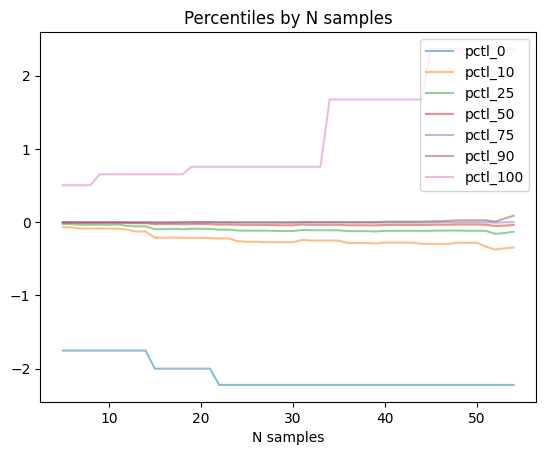

In [48]:
for k, v in results.items():
    if k.startswith('pctl'):
        plt.plot(np.arange(N)+n0, v, alpha=0.5, label=k)
plt.title('Percentiles by N samples')
plt.xlabel('N samples')
plt.legend()
plt.show()